In [1]:
from joblib import dump, load

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF

In [2]:
# ----- Load Data -----
notebook_folder = os.path.dirname(os.path.abspath("train.ipynb"))
data = np.concatenate([
    np.load(os.path.join(
        notebook_folder,
        "..", "data",
        "cyberglove_{:s}.npz".format(datatype)
    ), allow_pickle=True)['data'][:, :4]
    for datatype in ["base", "center", "thumb"]
])
target = np.concatenate([
    np.load(os.path.join(
        notebook_folder,
        "..", "data",
        "allegro_{:s}.npz".format(datatype)
    ), allow_pickle=True)['data'][:, -4:]
    for datatype in ["base", "center", "thumb"]
])

df = pd.DataFrame(
    np.hstack([data, target]),
    columns=["cyberglove_{:d}".format(i) for i in range(4)] +
            ["allegro_{:d}".format(i) for i in range(4)],
)


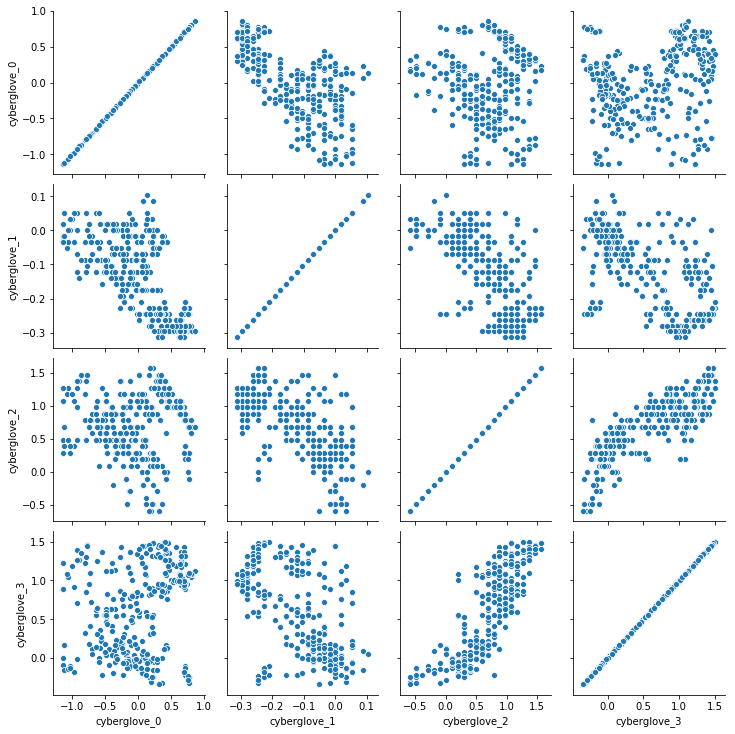

In [3]:
# ----- Plot Distribution -----
# g = sns.PairGrid(
#     df,
#     x_vars=["cyberglove_{:d}".format(i) for i in range(4)],
#     y_vars=["allegro_{:d}".format(i) for i in range(4)],
# )
g = sns.PairGrid(
    df,
    x_vars=["cyberglove_{:d}".format(i) for i in range(4)],
    y_vars=["cyberglove_{:d}".format(i) for i in range(4)],
)
# g.map(sns.kdeplot)
g.map(sns.scatterplot)
plt.show()

GPML kernel 0: RBF(length_scale=[0.951, 0.128, 0.979, 0.736]) + WhiteKernel(noise_level=0.0197)
GPML kernel 1: RBF(length_scale=[1.08, 0.19, 0.987, 0.649]) + WhiteKernel(noise_level=0.0205)
GPML kernel 2: RBF(length_scale=[2.37, 0.321, 1.75, 0.627]) + WhiteKernel(noise_level=0.0307)
GPML kernel 3: RBF(length_scale=[1.31, 0.489, 0.723, 0.506]) + WhiteKernel(noise_level=0.0672)


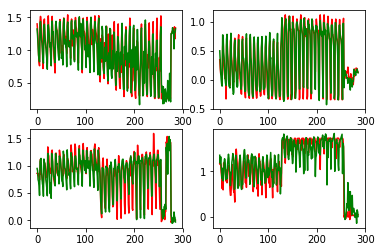

In [4]:
# ----- Train GPR Model -----
n_features = 4
n_output = 4

X = data[:, :n_features]

gp = [None] * n_output
for i in range(n_output):
    y = target[:, i]
    # Other possible kernels: DotProduct, RationalQuadratic, ExpSineSquared, Matern, RationalQuadratic
    kernel = RBF([1.0] * 4) + WhiteKernel()
    gp[i] = GaussianProcessRegressor(kernel=kernel, alpha=0, normalize_y=True).fit(X, y)

y_pred = [gp[i].predict(X) for i in range(n_output)]

for i in range(n_output):
    print("GPML kernel %d: %s" % (i, gp[i].kernel_))
    plt.subplot(2, 2, i+1)
    plt.plot(target[:, i], 'r-')
    plt.plot(y_pred[i], 'g-')
plt.show()

In [5]:
# -----  Save model to `joblib` file -----
dump(gp, os.path.join(
    notebook_folder,
    "..", "data",
    "trainedModel_GPR.joblib"
))

['/home/student-lasa/haptic_ws/src/Tools/allegro_hand_ros/allegro_hand_cyberglove/src/../data/trainedModel_GPR.joblib']

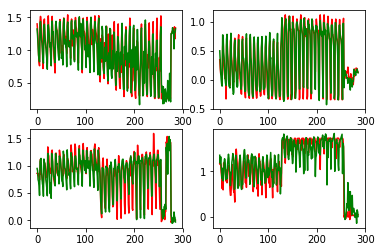

In [6]:
# -----  Verify saved model -----
model = load(os.path.join(
    notebook_folder,
    "..", "data",
    "trainedModel_GPR.joblib"
)) 
y_pred = [model[i].predict(X) for i in range(n_output)]

for i in range(n_output):
    plt.subplot(2, 2, i+1)
    plt.plot(target[:, i], 'r')
    plt.plot(y_pred[i], 'g')
plt.show()
